/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - loss: 0.0326 - val_loss: 0.0098
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.0051 - val_loss: 0.0093
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - loss: 0.0048 - val_loss: 0.0095
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - loss: 0.0046 - val_loss: 0.0103
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step - loss: 0.0040 - val_loss: 0.0096
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 0.0041 - val_loss: 0.0094
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0048 - val_loss: 0.0097
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0045 - val_loss: 0.0095
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0046 - val_loss: 0.0099
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0038 - val_loss: 0.0095
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


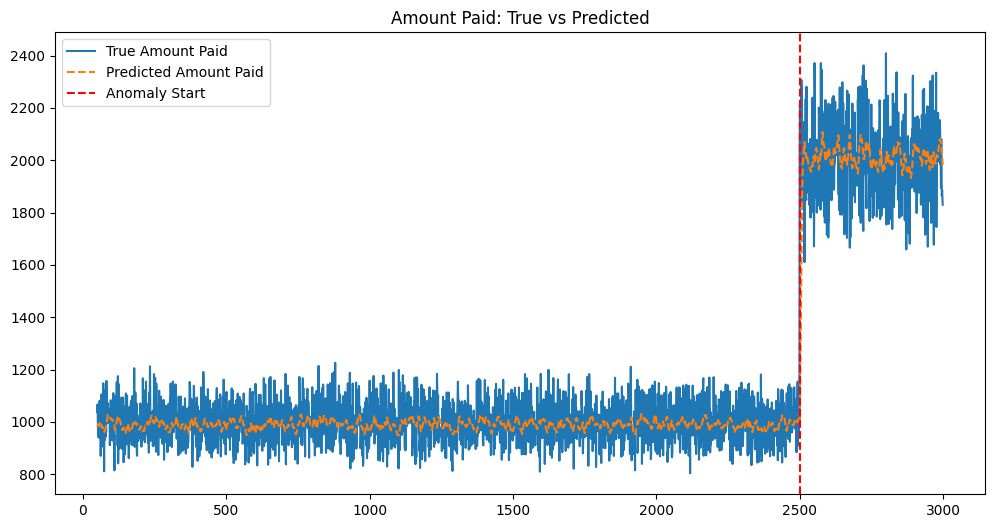

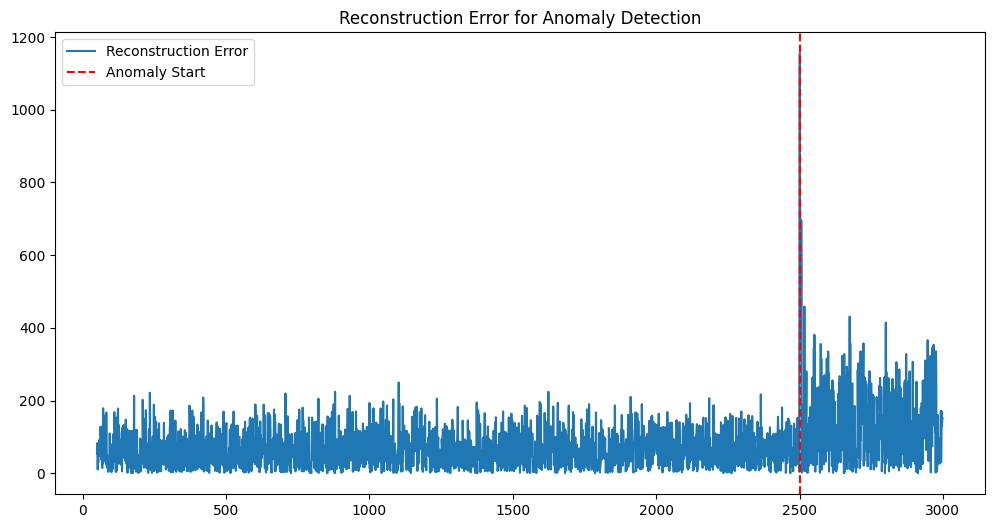

Anomalies detected at indices: Index([ 179,  209,  234,  420,  602,  707,  822,  875,  880,  931,
       ...
       2947, 2955, 2956, 2959, 2960, 2964, 2968, 2974, 2976, 2977],
      dtype='int64', length=148)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Step 1: Generate Synthetic Healthcare Payment Data
np.random.seed(42)
timesteps = 3000
anomaly_start = 2500
anomaly_factor = 2.0  # How much the anomaly should deviate from normal

# Create normal data for "Amount Allowed" and "Amount Paid"
amount_allowed = np.random.normal(1000, 50, timesteps)  # Normal range for allowed amount
amount_paid = amount_allowed * (np.random.uniform(0.9, 1.1, timesteps))  # Slightly varying around allowed amount

# Introduce anomalies where the "Amount Paid" deviates significantly from "Amount Allowed"
amount_paid[anomaly_start:] = amount_paid[anomaly_start:] * anomaly_factor

# Create DataFrame
data = pd.DataFrame({
    'amount_allowed': amount_allowed,
    'amount_paid': amount_paid
})

# Data Preprocessing
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Create sequences of time-series data for LSTM
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
    return np.array(sequences)

sequence_length = 50  # Length of time window for LSTM
X = create_sequences(data_scaled, sequence_length)

# Use the amount_paid (the second column in the original dataset) as the target for prediction
y = data_scaled[sequence_length:, 1]

#Build the LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

#Train the LSTM Model
history = model.fit(X, y, epochs=10, batch_size=64, validation_split=0.1)

# Make Predictions and Detect Anomalies
y_pred = model.predict(X)
y_pred_inverse = scaler.inverse_transform(np.concatenate([data_scaled[sequence_length:, :1], y_pred], axis=1))

# Calculate reconstruction error (difference between true and predicted)
reconstruction_error = np.abs(y_pred_inverse[:, 1] - scaler.inverse_transform(data_scaled)[sequence_length:, 1])
# Plot the Results
plt.figure(figsize=(12, 6))
plt.plot(data.index[sequence_length:], data['amount_paid'][sequence_length:], label='True Amount Paid')
plt.plot(data.index[sequence_length:], y_pred_inverse[:, 1], label='Predicted Amount Paid', linestyle='dashed')
plt.axvline(x=anomaly_start, color='r', linestyle='--', label='Anomaly Start')
plt.title('Amount Paid: True vs Predicted')
plt.legend()
plt.show()

# Plot the reconstruction error
plt.figure(figsize=(12, 6))
plt.plot(data.index[sequence_length:], reconstruction_error, label='Reconstruction Error')
plt.axvline(x=anomaly_start, color='r', linestyle='--', label='Anomaly Start')
plt.title('Reconstruction Error for Anomaly Detection')
plt.legend()
plt.show()

# Detecting anomalies based on reconstruction error threshold
threshold = np.percentile(reconstruction_error, 95)  # 95th percentile
anomalies = data.index[sequence_length:][reconstruction_error > threshold]

print(f"Anomalies detected at indices: {anomalies}")
